In [13]:
import pandas as pd
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, log_loss
import matplotlib.pyplot as plt
import sys
from IPython.display import display
import numpy as np

import os

# Get the absolute path of the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add the parent directory to sys.path
sys.path.append(parent_dir)

import scripts.processing as processing
from prettytable import PrettyTable

In [4]:
df = pd.read_csv("../data/submissions.csv")
eviction_df = processing.clean_for_eviction(df)
layoff_df = processing.clean_for_layoff(df)

In [5]:
# Define a function to calculate error metrics for each model
def compute_error_metrics(group):
    brier_score = brier_score_loss(group['truth'], group['prediction'])
    logloss = log_loss(group['truth'], group['prediction'])
    return pd.Series({'brier_score': brier_score, 'log_loss': logloss})

# Function to calculate custom calibration curve
def custom_calibration_curve(df, bins):
    temp_df = df.copy()
    temp_df.loc[:, 'bin'] = pd.cut(temp_df['prediction'], bins=bins, right=False, include_lowest=True)
    
    grouped = temp_df.groupby('bin', observed = False)
    calibration_data = grouped.agg(
        prob_pred=('prediction', 'mean'),
        frac_positives=('truth', 'mean'),
        count=('prediction', 'size')  # count the number of entries in each bin
    ).reset_index()
    
    return calibration_data


In [25]:
# Compute error metrics for each model
error_metrics = eviction_df.groupby('account', observed = False).apply(compute_error_metrics)

# Select top N models based on Brier score (or log_loss)
top_models = error_metrics.nsmallest(10, 'brier_score').index


# bins = np.arange(0, 1.1, 0.1).tolist()

bins = [0, 0.05, 0.95, 1]

# Plot calibration curves for top models
fig, ax = plt.subplots()

for model in top_models:
    model_data = df[df['account'] == model]
    calibration_data = custom_calibration_curve(model_data, bins)
    ax.plot(calibration_data['prob_pred'], calibration_data['frac_positives'], marker='o', label=f'Model {model}')
    table = PrettyTable()
    table.field_names = ["Bin", "Count", "Pred. Prob.", "Frac. Positives"]
    table.title = f"Model {model}"
    for index, row in calibration_data.iterrows():
        table.add_row([row['bin'], row['count'], row['prob_pred'], row['frac_positives']])
    print(table)
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
ax.set_xlabel('Mean predicted probability')
ax.set_ylabel('Fraction of positives')
ax.set_title('Calibration Curve, Eviction')
ax.legend(fontsize = 'small')

plt.show()

SyntaxError: invalid syntax (528852455.py, line 10)

+-----------------------------------------------------------------+
|                        Model Pentlandians                       |
+------------+-------+---------------------+----------------------+
|    Bin     | Count |     Pred. Prob.     |   Frac. Positives    |
+------------+-------+---------------------+----------------------+
| [0.0, 0.1) |  2411 | 0.05070738620821234 | 0.053236539624924396 |
| [0.1, 0.2) |  1159 | 0.15628172871061527 | 0.14387351778656132  |
| [0.2, 0.3) |  2529 | 0.23967625976648277 | 0.23116399729302956  |
| [0.3, 0.4) |  249  | 0.32894995567536217 | 0.39379779099405265  |
| [0.4, 0.5) |   16  |  0.4249642661338293 |        0.625         |
| [0.5, 0.6) |   0   |         nan         |         nan          |
| [0.6, 0.7) |   0   |         nan         |         nan          |
| [0.7, 0.8) |   0   |         nan         |         nan          |
| [0.8, 0.9) |   0   |         nan         |         nan          |
| [0.9, 1.0) |   0   |         nan         |    

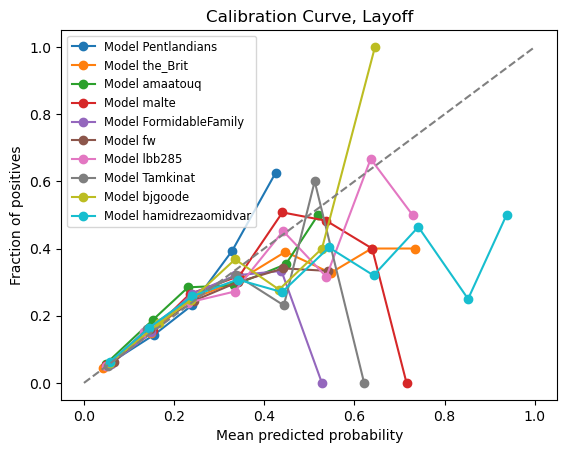

In [22]:
# Compute error metrics for each model
error_metrics = layoff_df.groupby('account', observed = False).apply(compute_error_metrics)

# select top models
top_models = error_metrics.nsmallest(10, 'brier_score').index

bins = [0, 0.2, 1]

bins = np.arange(0, 1.1, 0.1).tolist()

# Plot calibration curves for top models
fig, ax = plt.subplots()

for model in top_models:
    model_data = df[df['account'] == model]
    calibration_data = custom_calibration_curve(model_data, bins)
    ax.plot(calibration_data['prob_pred'], calibration_data['frac_positives'], marker='o', label=f'Model {model}')
    table = PrettyTable()
    table.field_names = ["Bin", "Count", "Pred. Prob.", "Frac. Positives"]
    table.title = f"Model {model}"
    for index, row in calibration_data.iterrows():
        table.add_row([row['bin'], row['count'], row['prob_pred'], row['frac_positives']])
    print(table)
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
ax.set_xlabel('Mean predicted probability')
ax.set_ylabel('Fraction of positives')
ax.set_title('Calibration Curve, Layoff')
ax.legend(fontsize = 'small')

plt.show()